# 3.2 面向对象设计的实现
在介绍线性回归时，本书探讨了各个组成部分，包括数据、模型、损失函数和优化算法。如你所想，线性回归就是最简单的机器学习模型之一。然而，训练它需要使用许多本书中其他模型所需的相同组件。因此，在深入研究实现细节之前，学习并设计我们在整个过程中使用的一些API是值得的。将深度学习中的组件作为对象进行处理，我们可以首先定义这些对象的类及其交互。面向对象的实现设计将极大地简化表示和使用方式，你甚至可能希望在自己的项目中也使用它。

受开源库如 PyTorch,Lightning 启发，从高层次来看，我们希望有三个类：(i) Module 包含模型、损失和优化方法；(ii) DataModule 提供训练和验证的数据加载器；(iii) 这两个类通过 Trainer 类结合在一起，它允许我们在各种硬件平台上训练模型。本书中的大部分代码都适配了 Module 和 DataModule。不过稍安勿躁，我们仅在后面讨论GPU、CPU、并行训练和优化算法时才会提到Trainer 类。

In [1]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
#常规的导包，没什么好说的

# 3.2.1 工具
我们需要一些工具来简化Jupyter笔记本中的面向对象编程。一个挑战是类定义往往是相当长的代码块，显然这并不适合我们所使用的jupyter notebook。为了notebook的可读性或者说使用规范，一般要求较短的代码片段，并且穿插解释说明，这与Python库常见的编程风格不兼容（这活该丢给pycharm去做）。

那在这里就不得不使用装饰器语法了（请原谅我不知道（懒狗）如何在jupyter中将这段加粗加黑）。

第一个实用函数允许我们在类创建之后，将函数注册为类的方法（你也许听不懂，但本质上就是为类添加新的功能）。
实际上，即使在创建类的实例之后我们也可以这样做！十分的简便口也！！！！它允许我们将类的实现拆分到多个代码块中。

In [5]:
def add_to_class(Class):  #@save
    """将函数注册为已创建类的方法"""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper




好吧,我来解释下这里做了什么  <br>
首先#@save仅是一个标记，这意味着后面的代码中还会用到这个函数<br>
add_to_class，顾名思义，功能是将函数添加到已经创建的类中<br>
函数wrapper，将传入的对象 obj（一个函数）动态地作为类 Class 的一个方法，方法名为 obj 的名字（即 obj.__name__）<br>
什么？！你要问我问什么要强调动态？？？因为是程序运行时为类或对象添加属性或方法，而不是在代码编写时静态地定义，别急，看了下面例子会加深你的理解<br>
最后返回wrapper函数,这意味着我们可以用它来装饰任何想要添加到类中的函数<br>

来，让我们康康这个东西该怎么用（喜

In [9]:
class A:
    def __init__(self):
        self.b = 1

a = A()
#声明类A并创建一个实例a

接着定义 do 方法，但不在类 A 的范围内定义。相反，我们通过 add_to_class 装饰这个方法，并将类 A 作为它的参数。这样一来，这个方法就可以像预期那样访问类 A 的成员变量，让我们看看当我们为实例 a 调用它时会发生什么。

In [10]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

#结果显而易见,do被正确地放入了类A中,更加重要的是，对象a也同步修改
#Python 中类和实例的行为是动态的，一旦类 A 中添加了新方法，所有基于 A 的对象实例都会立即获得该方法的访问权限。
#换句话说，a 实例已经被创建，但它依然会继承类 A 的所有最新的变化——包括通过装饰器动态添加的 do 方法

Class attribute "b" is 1


<br/>
<br/>
<br/>
第二个例子是一个实用类，它将类的 init 方法中的所有参数保存为类的属性。这使得我们可以隐式扩展构造函数调用的签名，而无需额外的代码。

In [11]:
class HyperParameters:  # @save
    """超参数的基类"""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented


它的具体实现在第23.7节才会讲。
<br/>要使用它，我们定义一个从 HyperParameters 继承的类，并在 __init__ 方法中调用 save_hyperparameters。

In [12]:
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)
#这一段只有print('There is no self.c =', not hasattr(self, 'c'))值得说下
#毕竟这个类的具体实现都还没讲,可以看到ignore=['c']，这意味着在保存超参数时忽略形参 c
#所以not hasattr(self, 'c')) 会输出True  (not)取反，hasattr检查当前对象是否有属性c

self.a = 1 self.b = 2
There is no self.c = True


<br/>
<br/>
最后一个实用工具允许我们在实验进行过程中以交互方式绘制实验进度图。参考功能更强大（也更复杂）的 TensorBoard，我们将其命名为 ProgressBoard。其实现推迟到 23.7 节。现在让我们简单看看它的实际效果。
<br/>
draw 方法在图形中绘制一个点 (x, y)，其中 label 会在图例中指定。可选参数 every_n 通过仅显示图中每 n 个点来平滑曲线。它们的值是从原始图形中 n 个相邻点的平均值。

In [13]:
class ProgressBoard(d2l.HyperParameters):  # @save
    """用于绘制动画中数据点的板"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

#画图，没什么好讲的

在下面的例子中，我们绘制了 sin 和 cos 函数，并使用了不同的平滑度。如果你运行这个代码块，将看到这些线条以动画形式逐渐增长。

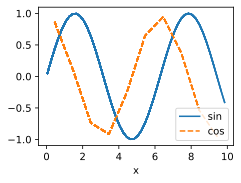

In [15]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

# 3.2.2 模型（Models）

Module 类是我们将实现的所有模型的基础类。至少我们需要三个方法。第一个是  **`__init__`**（好吧，我学会如何加黑了) 它存储可学习的参数；  
__training_step__ ,这个方法接受一批数据并返回损失值；最后，configure_optimizers 方法返回用于更新可学习参数的优化方法（或方法列表）。
<br/>可选方法：我们可以定义 __validation_step__ 来报告评估指标。有时，我们会将计算输出的代码放在一个单独的 __forward__ 方法中，以使其更具可重用性。

In [16]:
class Module(nn.Module, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

重头戏来了，我们来解析一下
# Module __init__
该类继承了 __torch.nn.Module__，因此可以作为 PyTorch 模型的基础类。  
还继承了 __d2l.HyperParameters__ ，保存和管理超参数。  
__init__ 方法中调用了 super().__init__() 来初始化父类，并且使用 self.save_hyperparameters() 保存构造函数中的超参数,这我在上面有提到过。  
self.board = ProgressBoard() 创建了一个 ProgressBoard 实例，用于绘制训练和验证的过程数据。  
# loss
这是一个抽象方法，表示需要在具体模型中实现该方法，用于计算模型的损失函数。  
由于该方法在 Module 类中没有实现，因此抛出了 NotImplementedError，不必着急，在后面会实现的
# forward
forward 方法是 PyTorch 模型中必须实现的，用于定义输入 X 经过神经网络的前向传播过程。  
该方法首先检查是否存在 net 属性，net 是具体的神经网络模型。如果不存在，抛出错误提示。  
如果存在，self.net(X) 会将输入 X 通过网络，返回输出。  

此处assert语法为 assert 条件, 错误信息（可选）  
如果条件为 True，程序继续执行；如果为 False，程序会抛出错误信息
# plot 
没什么好说的
# train_step
training_step 方法用于处理训练时的一个批次数据。  
它接收一个批次 (batch)，前面的元素（batch[:-1]）作为模型的输入，最后一个元素（batch[-1]）是标签。  
计算损失 l，并调用 plot 方法绘制训练的损失曲线。  
返回损失 l。  

# validation_step
validation_step 方法用于处理验证时的一个批次数据。  
同样，计算损失 l，并调用 plot 方法绘制验证的损失曲线。  
不返回损失，且train为false  

# configure_optimizers(self):

这是一个抽象方法，需要在具体模型中实现，定义模型的优化器（如 SGD、Adam 等）。  
由于没有实现具体内容，因此抛出 NotImplementedError，提示用户在子类中实现该方法。


   
  
    
  
Module 是 nn.Module 的子类，这是 PyTorch 中神经网络的基础类。它提供了一些方便的功能来处理神经网络。例如，如果我们定义了一个 forward 方法，如 forward(self, X)，那么对于一个实例 a，我们可以通过 a(X) 来调用这个方法。这是因为它调用了内置的 __call__ 方法中的 forward 方法。你可以在 6.1节 找到更多关于 nn.Module 的细节和示例。



# 3.2.3 Data
DataModule 类是数据的基础类。通常，`__init__` 方法用于准备数据，这包括数据下载和预处理（如果需要）。train_dataloader 返回训练数据集的加载器。数据加载器是一个（Python）生成器，每次使用时会产生一个数据批次。这个批次然后会被输入到 Module 类的 training_step 方法中以计算损失。此外还有一个可选的 val_dataloader，它返回验证数据集的加载器。其行为与 train_dataloader 类似，只是它为 Module 类中的 validation_step 方法提供数据批次。

In [18]:
class DataModule(d2l.HyperParameters):  #@save
    """数据的基础类"""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

#经过上面的讲解,相信你一定能读懂这段代码了 ,此处不再过多赘述

# 3.2.4 训练（Training）
Trainer 类负责使用 DataModule 指定的数据训练 Module 类中的可学习参数。关键方法是 fit，它接受两个参数：model，即一个 Module 实例，以及 data，即一个 DataModule 实例。然后它遍历整个数据集 max_epochs 次来训练模型。与之前一样，我们将在后面的章节中实现这个方法的细节。

In [20]:
class Trainer(d2l.HyperParameters):  # @save
    """带有数据的模型训练基类"""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, '暂不支持 GPU'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

#没有新东西,不过多赘述

# 3.2.5 总结
为了突出面向对象设计在我们未来深度学习实现中的作用，上述类简单地展示了它们的对象如何存储数据并相互交互。我们将继续丰富这些类的实现，例如在书的后面部分通过 @add_to_class。此外，这些完全实现的类被保存在 D2L 库 中，这是一个轻量级工具包，旨在让深度学习的结构化建模变得更加简单。特别是，它有助于在项目之间重用许多组件，而几乎不需要做任何更改。例如，我们可以只替换优化器、模型、数据集等。这种模块化的程度在整本书中都体现出了它的简洁性和便利性（这也是我们添加它的原因），并且它可以在你的项目中发挥同样的作用。  
  
d2l库在你下载的那个文件夹中可以看到

# 习题解答
1.找到保存在 D2L 库 中的上述类的完整实现。我们强烈建议你在对深度学习建模有更多熟悉后详细查看这些实现。  
  
我在上面说过了  

2.移除类 B 中的 save_hyperparameters 语句。你还能打印 self.a 和 self.b 吗？可选：如果你深入了解了 HyperParameters 类的完整实现，你能解释为什么吗？  
不能打印，这是因为 save_hyperparameters 的功能是自动将构造函数中的参数保存为类的属性。如果没有这个方法，参数不会自动保存为实例属性。删掉的话B里面压根就没申明任何保存参数的代码，除非你手动为这些参数设置属性。